# Titanic ML Pipeline — Full Notebook

This notebook contains the complete original pipeline you provided, with detailed **markdown explanations** and the full code for:

- EDA
- Three imputation strategies (Median / Group / Model-based)
- Feature engineering
- Model tuning (RandomForest, XGBoost)
- Ensemble (Voting)
- Evaluation and submission creation


## 1) Imports & Setup
Standard imports and optional XGBoost detection.

In [46]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Optional XGBoost import (if installed)
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    xgb_available = False

RANDOM_STATE = 42
print('xgboost available:', xgb_available)


xgboost available: True


## 2) Load dataset
Keep original path; raise error if not found.

In [47]:
if not os.path.exists('C:\\Users\\hienm\\OneDrive\\Desktop\\titanic_ML\\train.csv'):
    raise FileNotFoundError('train.csv not found in the working directory. Please upload it before running.')

train = pd.read_csv('C:\\Users\\hienm\\OneDrive\\Desktop\\titanic_ML\\train.csv')
print('train shape:', train.shape)
train.head()


train shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3) Quick EDA & visualizations

Missing values per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


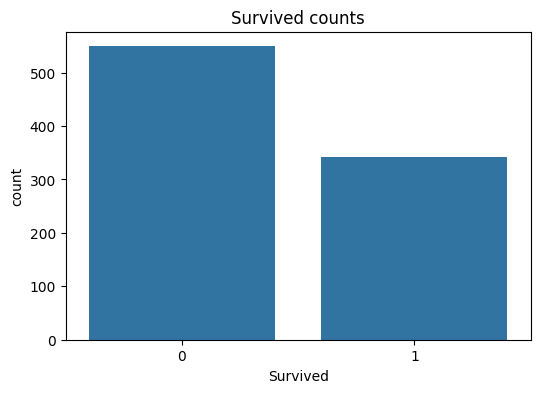

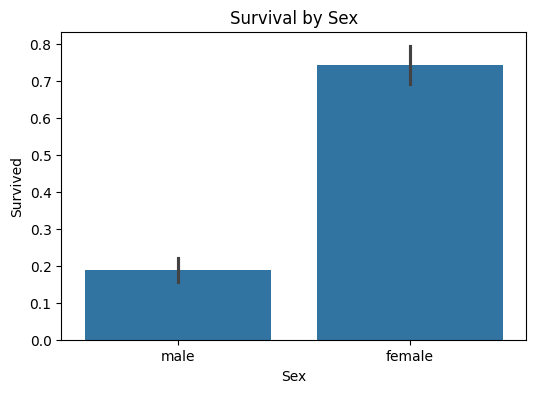

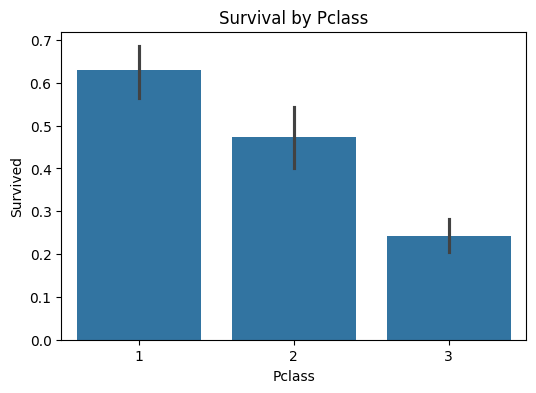

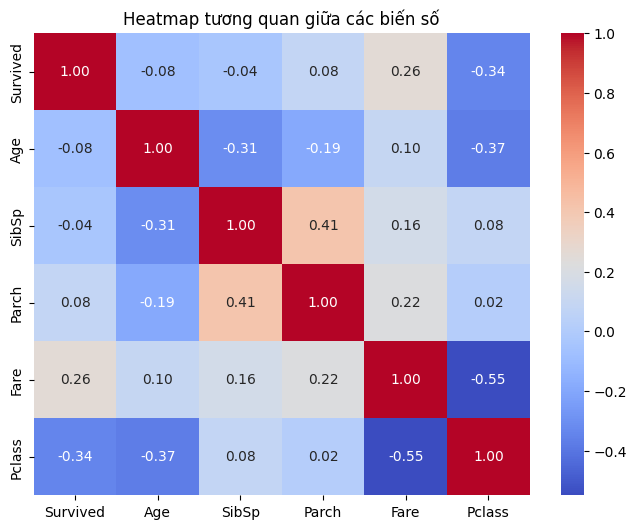

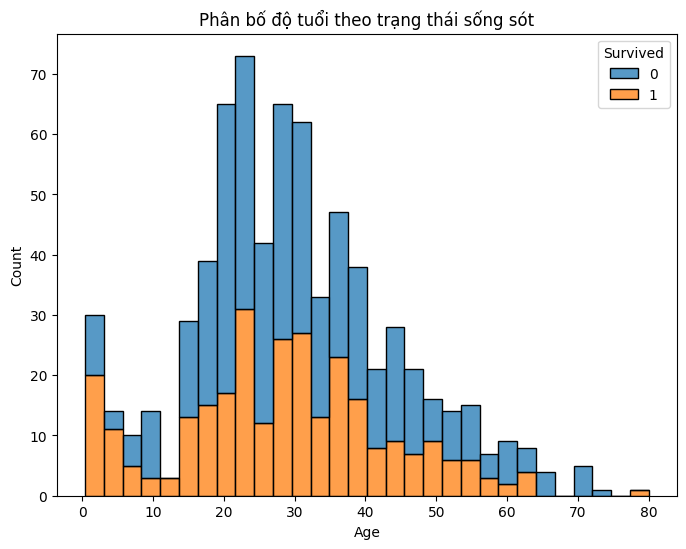

<Figure size 800x600 with 0 Axes>

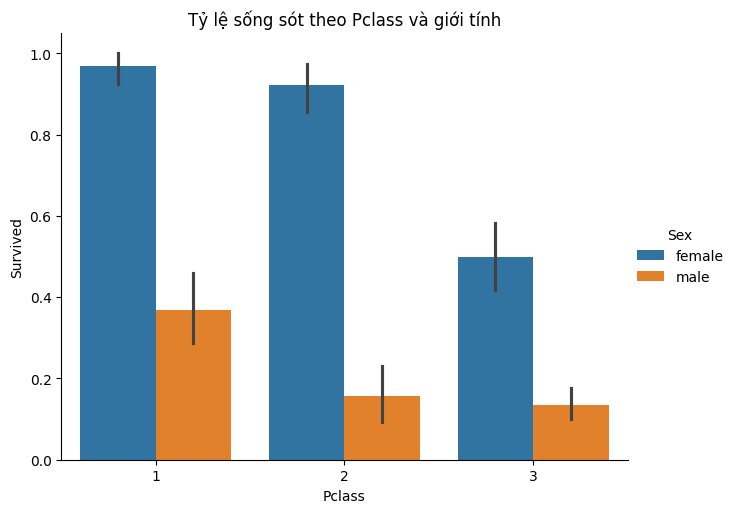

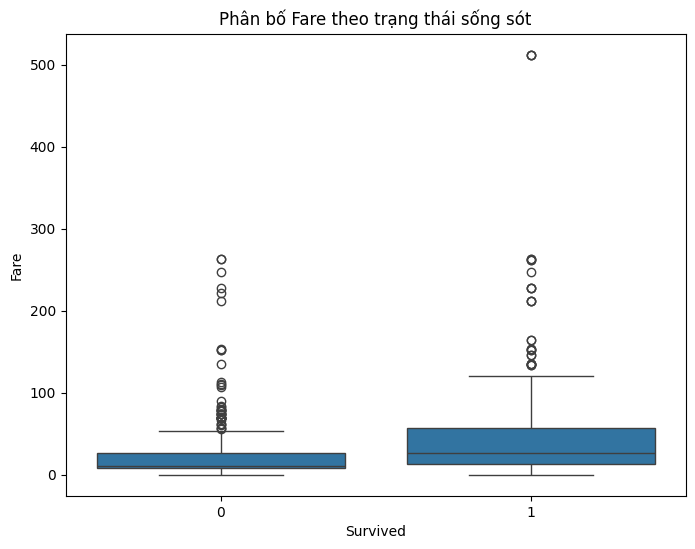

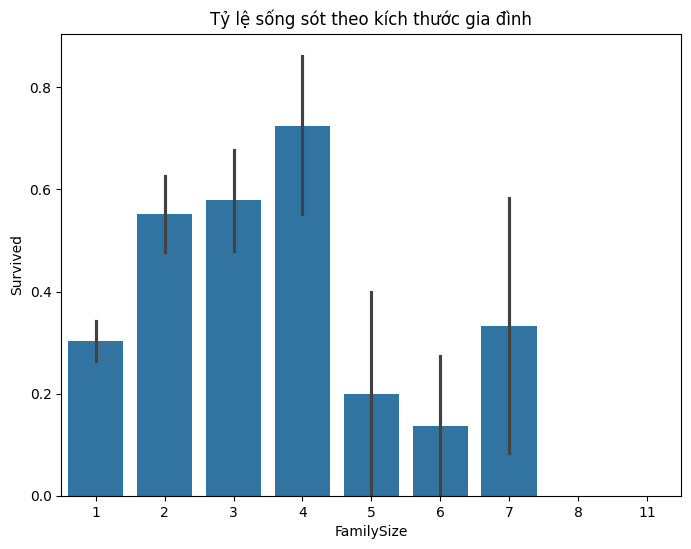

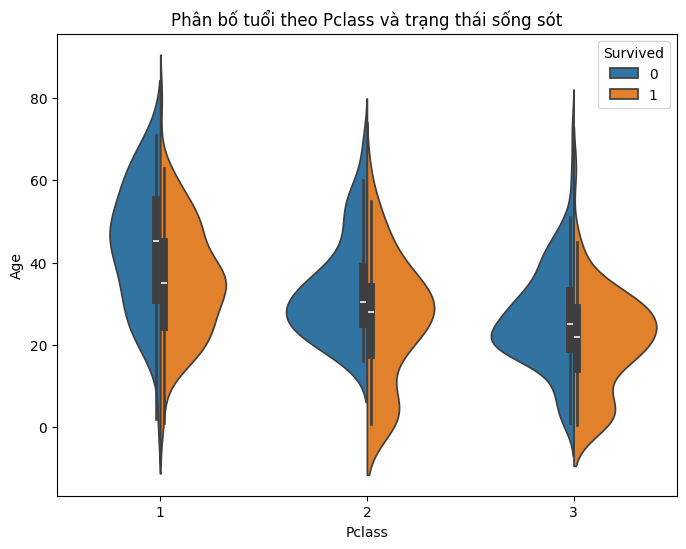

In [48]:
print('Missing values per column:')
print(train.isnull().sum())

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='Survived', data=train)
plt.title('Survived counts')
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival by Sex')
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title('Survival by Pclass')
plt.show()

# Heatmap
plt.figure(figsize=(8,6))
corr = train[['Survived','Age','SibSp','Parch','Fare','Pclass']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap tương quan giữa các biến số')
plt.show()

# Age distribution by survival
plt.figure(figsize=(8,6))
sns.histplot(data=train, x='Age', hue='Survived', multiple='stack', bins=30)
plt.title('Phân bố độ tuổi theo trạng thái sống sót')
plt.show()

# Survival by Pclass & Sex
plt.figure(figsize=(8,6))
sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, kind='bar', height=5, aspect=1.3)
plt.title('Tỷ lệ sống sót theo Pclass và giới tính')
plt.show()

# Fare boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x='Survived', y='Fare', data=train)
plt.title('Phân bố Fare theo trạng thái sống sót')
plt.show()

# FamilySize
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
plt.figure(figsize=(8,6))
sns.barplot(x='FamilySize', y='Survived', data=train)
plt.title('Tỷ lệ sống sót theo kích thước gia đình')
plt.show()

# Violin Age vs Pclass vs Survived
plt.figure(figsize=(8,6))
sns.violinplot(x='Pclass', y='Age', hue='Survived', data=train, split=True)
plt.title('Phân bố tuổi theo Pclass và trạng thái sống sót')
plt.show()


## 4) Create simple imputed variants & save (median / group / model)
This follows your original approach: median fill, group median fill, and model-based imputation for Age/Embarked.

In [49]:
# Variant: median imputation

df_median = train.copy()
# Age, Fare median; Embarked mode; Cabin -> HasCabin flag
df_median['Age'] = df_median['Age'].fillna(df_median['Age'].median())
df_median['Fare'] = df_median['Fare'].fillna(df_median['Fare'].median())
df_median['Embarked'] = df_median['Embarked'].fillna(df_median['Embarked'].mode()[0])
df_median['HasCabin'] = df_median['Cabin'].notnull().astype(int)
df_median = df_median.drop(columns=['Cabin'])
df_median.to_csv('train_variant_median.csv', index=False)
print('Saved train_variant_median.csv — shape', df_median.shape)
df_median.head()

# Variant: group imputation

df_group = train.copy()
df_group['HasCabin'] = df_group['Cabin'].notnull().astype(int)
# Map Sex temporarily for grouping
df_group['_sex_num'] = df_group['Sex'].map({'male':0,'female':1})
# Age filled by group median
df_group['Age'] = df_group.groupby(['_sex_num','Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
df_group['Age'] = df_group['Age'].fillna(df_group['Age'].median())
# Fare by Pclass median
df_group['Fare'] = df_group.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
df_group['Fare'] = df_group['Fare'].fillna(df_group['Fare'].median())
# Embarked mode fill
df_group['Embarked'] = df_group['Embarked'].fillna(df_group['Embarked'].mode()[0])

df_group = df_group.drop(columns=['Cabin','_sex_num'])
df_group.to_csv('train_variant_group.csv', index=False)
print('Saved train_variant_group.csv — shape', df_group.shape)
df_group.head()

# Variant: model-based imputation for Age & Embarked

df_model = train.copy()
# Create HasCabin
df_model['HasCabin'] = df_model['Cabin'].notnull().astype(int)
# Prepare Sex numeric for models
df_model['_Sex_num'] = df_model['Sex'].map({'male':0,'female':1})
# Ensure Fare has no missing (we'll fill with median temporarily so Age model can use it)
df_model['Fare'] = df_model['Fare'].fillna(df_model['Fare'].median())

# Predict Age
age_train = df_model[df_model['Age'].notnull()]
age_pred = df_model[df_model['Age'].isnull()]

age_features = ['Pclass','_Sex_num','SibSp','Parch','Fare','HasCabin']
if len(age_pred) > 0 and len(age_train) > 0:
    rfr = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE)
    rfr.fit(age_train[age_features], age_train['Age'])
    df_model.loc[df_model['Age'].isnull(), 'Age'] = rfr.predict(age_pred[age_features])
else:
    print('No missing Age to predict or insufficient data.')

# Encode Embarked temporarily (only for training the classifier)
emb_map = {'S':0, 'C':1, 'Q':2}
df_model['_Embarked_enc'] = df_model['Embarked'].map(emb_map)

emb_train = df_model[df_model['_Embarked_enc'].notnull()]
emb_pred = df_model[df_model['_Embarked_enc'].isnull()]

emb_features = ['Pclass','_Sex_num','SibSp','Parch','Fare','Age','HasCabin']
if len(emb_pred) > 0 and len(emb_train) > 0:
    clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
    clf.fit(emb_train[emb_features], emb_train['_Embarked_enc'])
    df_model.loc[df_model['_Embarked_enc'].isnull(), '_Embarked_enc'] = clf.predict(emb_pred[emb_features])
    # Map back to original labels
    inv_map = {v:k for k,v in emb_map.items()}
    df_model['Embarked'] = df_model['_Embarked_enc'].map(inv_map)
else:
    df_model['Embarked'] = df_model['Embarked'].fillna(df_model['Embarked'].mode()[0])

# Cleanup
df_model = df_model.drop(columns=['Cabin','_Sex_num','_Embarked_enc'])
df_model.to_csv('train_variant_model.csv', index=False)
print('Saved train_variant_model.csv — shape', df_model.shape)
df_model.head()


Saved train_variant_median.csv — shape (891, 13)
Saved train_variant_group.csv — shape (891, 13)
Saved train_variant_model.csv — shape (891, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0


## 5) Original Feature Engineering (quick run) and then a reusable function

In [50]:
try:
    df = train.copy()
except:
    pass

print(" Bắt đầu Feature Engineering...")

# 1️ FamilySize - tổng số người trong gia đình
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# 2️ IsAlone - có đi một mình không
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

# 3️ Title - trích xuất danh xưng từ Name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major',
                                   'Rev','Sir','Jonkheer','Dona'], 'Rare')
df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

# 4️ FarePerPerson - chia giá vé theo số người
df['FarePerPerson'] = df['Fare'] / df['FamilySize']

# 5️ Deck - ký tự đầu của Cabin
df['Deck'] = df['Cabin'].astype(str).str[0]
df['Deck'] = df['Deck'].replace('n', 'Unknown')

# 6️ TicketPrefix - nhóm ký tự trước số trong Ticket
df['TicketPrefix'] = df['Ticket'].apply(lambda x: ''.join([c for c in x if not c.isdigit()]).strip().replace('.', '').replace('/', ''))
df['TicketPrefix'] = df['TicketPrefix'].replace('', 'None')

# 7️ Nhóm các giá trị hiếm để tránh quá nhiều biến dummy
rare_titles = df['Title'].value_counts()[df['Title'].value_counts() < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

rare_decks = df['Deck'].value_counts()[df['Deck'].value_counts() < 10].index
df['Deck'] = df['Deck'].replace(rare_decks, 'Rare')

# 8️ AgeBin và FareBin - phân nhóm tuổi và giá vé
df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 80], 
                      labels=['Child','Teen','Adult','MidAge','Senior'])
df['FareBin'] = pd.qcut(df['Fare'], 4, 
                        labels=['Low','Mid','High','VeryHigh'])

# 9️ Chuyển sang dạng category cho các cột phân loại
categorical_cols = ['Sex','Embarked','Title','Deck','TicketPrefix','AgeBin','FareBin']
for col in categorical_cols:
    df[col] = df[col].astype('category')

#  Lưu lại để dễ so sánh sau
df.to_csv("titanic_feature_v1.csv", index=False)

print(" Feature Engineering hoàn tất! Tổng số cột sau khi tạo:", len(df.columns))
print("Các cột mới:", [c for c in df.columns if c not in ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']])


 Bắt đầu Feature Engineering...
 Feature Engineering hoàn tất! Tổng số cột sau khi tạo: 20
Các cột mới: ['FamilySize', 'IsAlone', 'Title', 'FarePerPerson', 'Deck', 'TicketPrefix', 'AgeBin', 'FareBin']


In [51]:
def feature_engineer(df, save_path=None):
    df = df.copy()

    # =====  Family features =====
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['FamilyCategory'] = pd.cut(
        df['FamilySize'], bins=[0,1,4,7,11],
        labels=['Single','Small','Medium','Large']
    )

    # =====  Extract Title =====
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
    df['Title'] = df['Title'].replace(
        ['Mlle','Ms'],'Miss').replace('Mme','Mrs')
    df['Title'] = df['Title'].replace([
        'Lady','Countess','Capt','Col','Don','Dr','Major',
        'Rev','Sir','Jonkheer','Dona'],'Rare')

    # Map Title -> Typical Age group (feature insight)
    title_age_map = {
        'Master':'Child', 'Miss':'Young', 'Mr':'Adult',
        'Mrs':'Adult', 'Rare':'Varied'
    }
    df['TitleAgeType'] = df['Title'].map(title_age_map).fillna('Varied')

    # =====  Deck =====n    
    if 'Cabin' in df.columns:
        df['Deck'] = df['Cabin'].astype(str).str[0]
        df['Deck'] = df['Deck'].replace('n', 'Unknown')
    else:
        df['Deck'] = 'Unknown'
    df['Deck'] = df['Deck'].replace(['T','G'], 'Rare')

    # =====  Ticket features =====
    df['TicketPrefix'] = df['Ticket'].apply(
        lambda x: ''.join([c for c in x if not c.isdigit()]).strip()
        .replace('.', '').replace('/', ''))
    df['TicketPrefix'] = df['TicketPrefix'].replace('', 'None')
    top_prefix = df['TicketPrefix'].value_counts().nlargest(10).index
    df['TicketPrefix'] = df['TicketPrefix'].apply(lambda x: x if x in top_prefix else 'Other')

    # Ticket length may correlate with class
    df['TicketLen'] = df['Ticket'].apply(len)

    # =====  Fare features =====
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']
    df['FarePerPerson'] = df['FarePerPerson'].replace([np.inf, -np.inf], np.nan)
    df['FarePerPerson'] = df['FarePerPerson'].fillna(df['FarePerPerson'].median())

    # Bin fare
    df['FareBin'] = pd.qcut(df['Fare'], 4, labels=['Low','Mid','High','VeryHigh'])

    # =====  Age features =====
    df['AgeBin'] = pd.cut(
        df['Age'], bins=[0,12,18,35,60,80],
        labels=['Child','Teen','Adult','Middle','Senior']
    )
    # Age * Pclass interaction — high impact feature
    df['AgeClass'] = df['Age'] * df['Pclass']

    # =====  Interaction features =====
    df['ClassSex'] = df['Pclass'].astype(str) + "_" + df['Sex']
    df['ClassEmbarked'] = df['Pclass'].astype(str) + "_" + df['Embarked'].astype(str)
    df['FareClass'] = df['Pclass'].astype(str) + "_" + df['FareBin'].astype(str)
    df['TitleSex'] = df['Title'].astype(str) + "_" + df['Sex'].astype(str)

    # =====  Derived survival insights =====
    df['WomenChild'] = ((df['Sex']=='female') | (df['Age']<16)).astype(int)
    df['HighClassFemale'] = ((df['Sex']=='female') & (df['Pclass']==1)).astype(int)

    # =====  Convert categorical =====
    categorical_cols = [
        'Sex','Embarked','Title','Deck','TicketPrefix',
        'AgeBin','FareBin','ClassSex','ClassEmbarked',
        'FareClass','TitleSex','FamilyCategory','TitleAgeType'
    ]
    for col in categorical_cols:
        df[col] = df[col].astype('category')

    # =====  Drop unused columns =====
    df = df.drop(columns=['PassengerId','Name','Ticket','Cabin'], errors='ignore')

    # =====  Save & info =====
    if save_path:
        df.to_csv(save_path, index=False)
    print(f" Feature engineering done for {save_path or 'DataFrame'}, total columns: {df.shape[1]}")
    return df


## 6) Split dataset early (prevent leakage) & define imputers (fit/apply)

In [52]:
from sklearn.model_selection import train_test_split

# Split immediately to avoid any leakage from using full dataset stats
raw_train, raw_val = train_test_split(
    train, test_size=0.2, stratify=train['Survived'], random_state=RANDOM_STATE
)
raw_train = raw_train.reset_index(drop=True)
raw_val = raw_val.reset_index(drop=True)
print(f"Split done: raw_train {raw_train.shape}, raw_val {raw_val.shape}")

# --- helper imputers that are FIT on train and APPLY to any dataframe ---
def fit_median_imputer(df):
    stats = {}
    stats['age_med'] = df['Age'].median()
    stats['fare_med'] = df['Fare'].median()
    stats['embarked_mode'] = df['Embarked'].mode()[0] if not df['Embarked'].mode().empty else 'S'
    return stats

def apply_median_imputer(df, stats):
    df = df.copy()
    df['Age'] = df['Age'].fillna(stats['age_med'])
    df['Fare'] = df['Fare'].fillna(stats['fare_med'])
    df['Embarked'] = df['Embarked'].fillna(stats['embarked_mode'])
    df['HasCabin'] = df['Cabin'].notnull().astype(int)
    df = df.drop(columns=['Cabin'], errors='ignore')
    return df

def fit_group_imputer(df):
    # compute medians on train by Sex+Pclass and Fare medians by Pclass, and embarked mode
    tmp = df.copy()
    tmp['_sex_num'] = tmp['Sex'].map({'male':0,'female':1})
    age_group_median = tmp.groupby(['_sex_num','Pclass'])['Age'].median()
    fare_pclass_median = tmp.groupby('Pclass')['Fare'].median()
    embarked_mode = tmp['Embarked'].mode()[0] if not tmp['Embarked'].mode().empty else 'S'
    return {'age_group_median': age_group_median, 'fare_pclass_median': fare_pclass_median, 'embarked_mode': embarked_mode}

def apply_group_imputer(df, stats):
    df = df.copy()
    df['_sex_num'] = df['Sex'].map({'male':0,'female':1})
    # age fill by group median where available, otherwise global median from group medians
    def fill_age(row):
        key = (row['_sex_num'], row['Pclass'])
        try:
            val = stats['age_group_median'].loc[key]
            return row['Age'] if not pd.isnull(row['Age']) else val
        except Exception:
            return row['Age']
    df['Age'] = df.apply(fill_age, axis=1)
    # fallback any remaining NaN
    df['Age'] = df['Age'].fillna(stats['age_group_median'].median())
    # Fare
    def fill_fare(row):
        pc = row['Pclass']
        try:
            val = stats['fare_pclass_median'].loc[pc]
            return row['Fare'] if not pd.isnull(row['Fare']) else val
        except Exception:
            return row['Fare']
    df['Fare'] = df.apply(fill_fare, axis=1)
    df['Fare'] = df['Fare'].fillna(stats['fare_pclass_median'].median())
    df['Embarked'] = df['Embarked'].fillna(stats['embarked_mode'])
    df['HasCabin'] = df['Cabin'].notnull().astype(int)
    df = df.drop(columns=['Cabin','_sex_num'], errors='ignore')
    return df

def fit_model_imputer(df):
    # Fit models for Age and Embarked using only training data
    tmp = df.copy()
    tmp['_Sex_num'] = tmp['Sex'].map({'male':0,'female':1})
    # Ensure Fare no missing for Age model
    fare_med = tmp['Fare'].median()
    tmp['Fare'] = tmp['Fare'].fillna(fare_med)
    tmp['HasCabin'] = tmp['Cabin'].notnull().astype(int)

    age_train = tmp[tmp['Age'].notnull()]
    age_features = ['Pclass','_Sex_num','SibSp','Parch','Fare','HasCabin']
    age_model = None
    if len(age_train) > 0:
        rfr = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE)
        rfr.fit(age_train[age_features], age_train['Age'])
        age_model = rfr

    # Embarked model
    emb_map = {'S':0, 'C':1, 'Q':2}
    tmp['_Embarked_enc'] = tmp['Embarked'].map(emb_map)
    emb_train = tmp[tmp['_Embarked_enc'].notnull()]
    emb_model = None
    if len(emb_train) > 0:
        clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
        emb_features = ['Pclass','_Sex_num','SibSp','Parch','Fare','Age','HasCabin']
        # For safety, drop rows with NaN in emb_features
        emb_train2 = emb_train.dropna(subset=emb_features + ['_Embarked_enc'])
        if len(emb_train2) > 0:
            clf.fit(emb_train2[emb_features], emb_train2['_Embarked_enc'])
            emb_model = clf

    return {'age_model': age_model, 'emb_model': emb_model, 'fare_med': fare_med, 'emb_map': emb_map}

def apply_model_imputer(df, models):
    df = df.copy()
    df['_Sex_num'] = df['Sex'].map({'male':0,'female':1})
    df['Fare'] = df['Fare'].fillna(models['fare_med'])
    df['HasCabin'] = df['Cabin'].notnull().astype(int)

    age_model = models['age_model']
    if age_model is not None:
        age_pred_idx = df['Age'].isnull()
        if age_pred_idx.any():
            age_features = ['Pclass','_Sex_num','SibSp','Parch','Fare','HasCabin']
            df.loc[age_pred_idx, 'Age'] = age_model.predict(df.loc[age_pred_idx, age_features])

    emb_model = models['emb_model']
    if emb_model is not None:
        emb_map = models['emb_map']
        emb_inv = {v:k for k,v in emb_map.items()}
        emb_missing = df['Embarked'].isnull()
        if emb_missing.any():
            emb_features = ['Pclass','_Sex_num','SibSp','Parch','Fare','Age','HasCabin']
            # drop rows with NaN in features used by model
            rows = df.loc[emb_missing].dropna(subset=emb_features)
            if not rows.empty:
                pred = emb_model.predict(rows[emb_features])
                df.loc[rows.index, 'Embarked'] = [emb_inv.get(int(p), np.nan) for p in pred]
        df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode().iloc[0] if not df['Embarked'].mode().empty else 'S')

    df = df.drop(columns=['Cabin','_Sex_num'], errors='ignore')
    return df


Split done: raw_train (712, 13), raw_val (179, 13)


## 7) Fit imputers on raw_train and transform raw_train/raw_val for each variant
We save feature-engineered train/val files for each variant (median/group/model).

In [53]:
# Fit on raw_train and transform both train and val for each variant
# Median variant
median_stats = fit_median_imputer(raw_train)
median_train = apply_median_imputer(raw_train, median_stats)
median_val   = apply_median_imputer(raw_val, median_stats)

# Group variant
group_stats = fit_group_imputer(raw_train)
group_train = apply_group_imputer(raw_train, group_stats)
group_val   = apply_group_imputer(raw_val, group_stats)

# Model variant
model_stats = fit_model_imputer(raw_train)
model_train = apply_model_imputer(raw_train, model_stats)
model_val   = apply_model_imputer(raw_val, model_stats)

# Now run feature engineering separately on train and val (feature_engineer does not peek at labels)
fe_median_train = feature_engineer(median_train, save_path='train_median_features_train.csv')
fe_median_val   = feature_engineer(median_val, save_path='train_median_features_val.csv')

fe_group_train = feature_engineer(group_train, save_path='train_group_features_train.csv')
fe_group_val   = feature_engineer(group_val, save_path='train_group_features_val.csv')

fe_model_train = feature_engineer(model_train, save_path='train_model_features_train.csv')
fe_model_val   = feature_engineer(model_val, save_path='train_model_features_val.csv')

# Save in filenames expected later (median_impute_train.csv etc.)
fe_median_train.to_csv('median_impute_train.csv', index=False)
fe_median_val.to_csv('median_impute_val.csv', index=False)
fe_group_train.to_csv('group_impute_train.csv', index=False)
fe_group_val.to_csv('group_impute_val.csv', index=False)
fe_model_train.to_csv('model_impute_train.csv', index=False)
fe_model_val.to_csv('model_impute_val.csv', index=False)

print("Saved variant train/val files without data leakage (imputers/models fitted on train only).")


 Feature engineering done for train_median_features_train.csv, total columns: 27
 Feature engineering done for train_median_features_val.csv, total columns: 27
 Feature engineering done for train_group_features_train.csv, total columns: 27
 Feature engineering done for train_group_features_val.csv, total columns: 27
 Feature engineering done for train_model_features_train.csv, total columns: 27
 Feature engineering done for train_model_features_val.csv, total columns: 27
Saved variant train/val files without data leakage (imputers/models fitted on train only).


## 8) Outlier capping, preprocessing and GridSearch tuning (Median variant used for tuning)

In [54]:
from sklearn.model_selection import train_test_split

def split_and_save(df, variant_name, test_size=0.2, random_state=RANDOM_STATE):
    """
    Chia dataset thành train và validation, đảm bảo stratify theo 'Survived'.
    """
    X_train, X_val, y_train, y_val = train_test_split(
        df.drop(columns=['Survived']),
        df['Survived'],
        test_size=test_size,
        random_state=random_state,
        stratify=df['Survived']
    )
    
    # Ghép lại để lưu thành CSV
    train_df = pd.concat([X_train, y_train], axis=1)
    val_df = pd.concat([X_val, y_val], axis=1)
    
    train_path = f'{variant_name.lower().replace(" ", "_")}_train.csv'
    val_path = f'{variant_name.lower().replace(" ", "_")}_val.csv'
    
    train_df.to_csv(train_path, index=False)
    val_df.to_csv(val_path, index=False)
    
    print(f' Saved {train_path} ({train_df.shape}) and {val_path} ({val_df.shape})')
    return train_df, val_df
median_train, median_val = split_and_save(fe_median_train, 'Median Impute')
group_train, group_val = split_and_save(fe_group_train, 'Group Impute')
model_train, model_val = split_and_save(fe_model_train, 'Model Impute')

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.exceptions import NotFittedError
import pandas as pd

# Nếu bạn có XGBoost thì bật
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

RANDOM_STATE = 42

# ============================================
# 🔹 Đọc lại các bộ dữ liệu đã chia
# ============================================
median_train = pd.read_csv('median_impute_train.csv')
median_val   = pd.read_csv('median_impute_val.csv')
group_train  = pd.read_csv('group_impute_train.csv')
group_val    = pd.read_csv('group_impute_val.csv')
model_train  = pd.read_csv('model_impute_train.csv')
model_val    = pd.read_csv('model_impute_val.csv')

# ====== XỬ LÝ OUTLIERS ======
def cap_outliers(df, numeric_cols=None, lower_quantile=0.01, upper_quantile=0.99):
    """
    Cắt các giá trị ngoại lệ theo percentiles (1%-99% mặc định)
    df: dataframe
    numeric_cols: danh sách cột numeric cần xử lý, nếu None sẽ lấy tất cả numeric
    """
    df = df.copy()
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for col in numeric_cols:
        lower = df[col].quantile(lower_quantile)
        upper = df[col].quantile(upper_quantile)
        df[col] = df[col].clip(lower=lower, upper=upper)
    
    return df

# Ví dụ áp dụng trên các variant sau khi imputing
numeric_cols = ['Age','Fare','SibSp','Parch']  # cột numeric chính
median_train = cap_outliers(median_train, numeric_cols)
median_val   = cap_outliers(median_val, numeric_cols)
group_train  = cap_outliers(group_train, numeric_cols)
group_val    = cap_outliers(group_val, numeric_cols)
model_train  = cap_outliers(model_train, numeric_cols)
model_val    = cap_outliers(model_val, numeric_cols)

# ============================================
# 🔹 Feature preprocessing chung
# ============================================
X_sample = median_train.drop('Survived', axis=1)
cat_cols = X_sample.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_sample.select_dtypes(exclude=['object', 'category']).columns.tolist()

pre = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

# ============================================
# 🔹 Tuning mô hình (chỉ làm 1 lần trên Median Impute)
# ============================================
X = median_train.drop('Survived', axis=1)
y = median_train['Survived']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# === 1. Tuning RandomForest ===
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_pipe = Pipeline([
    ('pre', pre),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))
])

rf_grid = GridSearchCV(
    rf_pipe,
    param_grid={'model__' + k: v for k, v in rf_param_grid.items()},
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)
print(" Best RF Params:", rf_grid.best_params_)
print(" Best RF CV Accuracy:", rf_grid.best_score_)
best_rf = rf_grid.best_estimator_.named_steps['model']

# === 2. Tuning XGBoost ===
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_pipe = Pipeline([
    ('pre', pre),
    ('model', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_STATE))
])

xgb_grid = GridSearchCV(
    xgb_pipe,
    param_grid={'model__' + k: v for k, v in xgb_param_grid.items()},
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)
print(" Best XGB Params:", xgb_grid.best_params_)
print(" Best XGB CV Accuracy:", xgb_grid.best_score_)
best_xgb = xgb_grid.best_estimator_.named_steps['model']

 Saved median_impute_train.csv ((569, 27)) and median_impute_val.csv ((143, 27))
 Saved group_impute_train.csv ((569, 27)) and group_impute_val.csv ((143, 27))
 Saved model_impute_train.csv ((569, 27)) and model_impute_val.csv ((143, 27))
Fitting 5 folds for each of 108 candidates, totalling 540 fits
 Best RF Params: {'model__max_depth': 4, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 300}
 Best RF CV Accuracy: 0.8285714285714285
Fitting 5 folds for each of 72 candidates, totalling 360 fits
 Best XGB Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
 Best XGB CV Accuracy: 0.8241758241758241


## 9) Build Voting Classifier safely (handle XGB availability)

In [55]:
# =====================================
#  Voting Classifier (chuẩn sklearn 1.7 + xgboost 2.1)
# =====================================
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.base import is_classifier, clone, BaseEstimator, ClassifierMixin

# Lấy best models từ GridSearchCV (đảm bảo lấy đúng bước cuối)
best_rf  = rf_grid.best_estimator_.named_steps['model']
best_xgb = xgb_grid.best_estimator_.named_steps['model']

print("Type of best_xgb:", type(best_xgb))
print("Is classifier before fix:", is_classifier(best_xgb))

# Thay vì cố gắng "wrap" một instance đã fit (có thể không được sklearn nhận diện),
# ta khởi tạo một XGBClassifier mới với các tham số tốt nhất (nếu có) — đảm bảo là sklearn estimator.
xgb_estimator = None
if xgb_available:
    try:
        # Lấy params sạch từ xgb_grid.best_params_
        xgb_best_params = {
            k.replace('model__', ''): v
            for k, v in xgb_grid.best_params_.items()
            if k.startswith('model__')
        }
    except Exception:
        xgb_best_params = {}

    # Chỉ giữ các params hợp lệ (bảo vệ nếu grid chứa key lạ)
    try:
        # tạo instance mặc định để lấy danh sách params hợp lệ
        tmp = XGBClassifier()
        valid_keys = set(tmp.get_params().keys())
        safe_params = {k: v for k, v in xgb_best_params.items() if k in valid_keys}
        # đảm bảo các tham số dùng phiên bản XGBoost hiện tại
        xgb_estimator = XGBClassifier(
            **safe_params,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=RANDOM_STATE,
            n_jobs=1
        )
    except Exception as e:
        print(" Không thể khởi tạo XGB từ best_params, khởi tạo mặc định:", e)
        try:
            xgb_estimator = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_STATE, n_jobs=1)
        except Exception as e2:
            print(" XGBoost không khả dụng:", e2)
            xgb_estimator = None

    print("Is classifier new_xgb:", is_classifier(xgb_estimator))

    # Nếu sklearn không nhận dạng là classifier → bỏ qua XGB trong ensemble
    if xgb_estimator is not None and not is_classifier(xgb_estimator):
        print(" XGB instance is not recognized as a sklearn classifier — sẽ không thêm vào ensemble.")
        xgb_estimator = None

# Tạo danh sách estimators cho Voting (bỏ XGB nếu không khả dụng)
log_reg = LogisticRegression(max_iter=500, random_state=42)
estimators = [('lr', log_reg), ('rf', best_rf)]
if xgb_estimator is not None:
    estimators.append(('xgb', xgb_estimator))
else:
    print(" XGB không được thêm vào ensemble vì không khả dụng hoặc không hợp lệ.")

# VotingClassifier: đặt n_jobs=1 để tránh nested parallelism
voting = VotingClassifier(
    estimators=estimators,
    voting='soft',
    n_jobs=1
)

pipe_voting = Pipeline([
    ('pre', pre),
    ('model', voting)
])

pipe_voting.fit(X_train, y_train)
val_preds = pipe_voting.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)
print(f" Voting Accuracy: {val_acc:.4f}")

Type of best_xgb: <class 'xgboost.sklearn.XGBClassifier'>
Is classifier before fix: False
Is classifier new_xgb: False
 XGB instance is not recognized as a sklearn classifier — sẽ không thêm vào ensemble.
 XGB không được thêm vào ensemble vì không khả dụng hoặc không hợp lệ.
 Voting Accuracy: 0.8509


## 10) Evaluate each imputation variant using tuned models

In [56]:
# ============================================
# 🔹 Hàm đánh giá từng biến thể (dùng mô hình đã tuning)
def evaluate_variant(train_df, val_df, variant_name):
    results = []
    X_train = train_df.drop('Survived', axis=1)
    y_train = train_df['Survived']
    X_val = val_df.drop('Survived', axis=1)
    y_val = val_df['Survived']

    models = {
        'Logistic': LogisticRegression(max_iter=500),
        'RandomForest': best_rf,
        'XGBoost': best_xgb,
        'Voting': voting
    }

    for name, mdl in models.items():
        try:
            pipe = Pipeline([('pre', pre), ('model', mdl)])
            pipe.fit(X_train, y_train)
            preds = pipe.predict(X_val)
            acc = accuracy_score(y_val, preds)
            print(f" {variant_name} | {name} Accuracy: {acc:.4f}")
            results.append({'Variant': variant_name, 'Model': name, 'Accuracy': acc})
        except Exception as e:
            print(f" {variant_name} | {name} failed: {e}")
    return results
#  Đánh giá từng biến thể
results = []
results += evaluate_variant(median_train, median_val, 'Median Impute')
results += evaluate_variant(group_train, group_val, 'Group Impute')
results += evaluate_variant(model_train, model_val, 'Model Impute')

# ============================================
#  Lưu kết quả
# ============================================
results_df = pd.DataFrame(results)
results_df.to_csv('model_accuracy_summary.csv', index=False)
print(" Kết quả đã lưu vào model_accuracy_summary.csv")
results_df

## ============================================
#  Chuẩn bị dữ liệu test và tạo file submission
# ============================================

# Đọc kết quả accuracy
results_df = pd.read_csv('model_accuracy_summary.csv')


 Median Impute | Logistic Accuracy: 0.8392
 Median Impute | RandomForest Accuracy: 0.8462
 Median Impute | XGBoost Accuracy: 0.8182
 Median Impute | Voting Accuracy: 0.8392
 Group Impute | Logistic Accuracy: 0.8252
 Group Impute | RandomForest Accuracy: 0.8462
 Group Impute | XGBoost Accuracy: 0.8182
 Group Impute | Voting Accuracy: 0.8392
 Model Impute | Logistic Accuracy: 0.8392
 Model Impute | RandomForest Accuracy: 0.8462
 Model Impute | XGBoost Accuracy: 0.8531
 Model Impute | Voting Accuracy: 0.8392
 Kết quả đã lưu vào model_accuracy_summary.csv


## 11) Train best model on full data (train+val) and create submission

In [57]:
# Read results
results_df = pd.read_csv('model_accuracy_summary.csv')

best_row = results_df.loc[results_df['Accuracy'].idxmax()]
best_variant = best_row['Variant']
best_model_name = best_row['Model']
print(f"Best Variant: {best_variant}, Best Model: {best_model_name}, Accuracy: {best_row['Accuracy']:.4f}")

variant_map = {
    'Median Impute': ('median_impute_train.csv', 'median_impute_val.csv'),
    'Group Impute': ('group_impute_train.csv', 'group_impute_val.csv'),
    'Model Impute': ('model_impute_train.csv', 'model_impute_val.csv')
}
train_path, val_path = variant_map[best_variant]
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)

full_train = pd.concat([train_df, val_df], axis=0).reset_index(drop=True)
X_full = full_train.drop('Survived', axis=1)
y_full = full_train['Survived']

# Determine preprocessor
cat_cols = X_full.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_full.select_dtypes(exclude=['object', 'category']).columns.tolist()
pre = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

# Choose model
if best_model_name == 'Logistic':
    model = LogisticRegression(max_iter=500, random_state=42)
elif best_model_name == 'RandomForest':
    model = best_rf
elif best_model_name == 'XGBoost':
    model = best_xgb
elif best_model_name == 'Voting':
    model = pipe_voting.named_steps['model']
else:
    raise ValueError(f"Unknown model: {best_model_name}")

final_pipe = Pipeline([('pre', pre), ('model', model)])
final_pipe.fit(X_full, y_full)
print(' Model đã fit trên toàn bộ train + val.')

# Load test
test = pd.read_csv('C:\\Users\\hienm\\OneDrive\\Desktop\\titanic_ML\\test.csv')
test['Fare'] = test['Fare'].fillna(X_full['Fare'].median())
test['Age'] = test['Age'].fillna(X_full['Age'].median())
test['Embarked'] = test['Embarked'].fillna(X_full['Embarked'].mode()[0])
test['HasCabin'] = test['Cabin'].notnull().astype(int)
test_fe = feature_engineer(test)

X_test = test_fe.drop(columns=['PassengerId'], errors='ignore')

# Predict and save submission
test_pred = final_pipe.predict(X_test)
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_pred.astype(int)
})
submission.to_csv('submission_best.csv', index=False)
print(' Saved submission_best.csv — ready to upload!')
submission.head()


Best Variant: Model Impute, Best Model: XGBoost, Accuracy: 0.8531
 Model đã fit trên toàn bộ train + val.
 Feature engineering done for DataFrame, total columns: 26
 Saved submission_best.csv — ready to upload!


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


----

Notebook created programmatically. Run cells in order. If XGBoost is not installed, XGB parts will be skipped.

If you want adjustments (reduce GridSearch params for speed, or run only certain parts), tell me and I will generate a trimmed notebook.